In [1]:
# Import machine-learning packages
import torch
from torch import nn

# Import plotting packages
from IPython.display import Image, HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import time
import base64
import numpy as np
import random

%matplotlib inline

# Creating Data-Sets

In [2]:
import xarray as xr
import glob
import pandas as pd

In [3]:
datasets = []
i_init = 1
flist = glob.glob("/Users/mbourget/Desktop/Icepack-Data/Arctic.sit1.*")

for file_path in flist:
    ds = xr.open_dataset(file_path, decode_times=False)
    time = ds['time']
    time_values = pd.to_datetime(time.values)
    new_time_values = [i for i in np.arange(i_init, len(time)+i_init)]
    new_time = xr.DataArray(new_time_values, dims='time', coords={'time': new_time_values})
    ds = ds.assign_coords(time=new_time)
    datasets.append(ds)
    i_init += len(time)

combined_ds = xr.concat(datasets, dim='time')

# Close all datasets
for ds in datasets:
    ds.close()
combined_ds.close()

In [4]:
data = combined_ds
input_vars = ["vice", "sst", "sss", "Tair", "Qa", "frain", "fsnow", "flw", "fsw"]
data_x = []
for var in input_vars:
    data_x += [data[var].values[:-1, 2]]
data_y_orig_thic = data.vice.values[1:,2]
data_y = data.vice.values[1:,2]-data.vice.values[0:-1,2]

In [6]:
len(data_x[0])/3

8759.666666666666

## Partitioning Data

In [7]:
num_t = len(data_x[0])
ind = np.arange(int(num_t*0.8))
index_test = np.arange(int(num_t*0.8), num_t)

#train_prop, val_prop, test_prop = 0.7, 0.15, 0.15

# 10 days train, 2 days validation, 2 days test
index_train = [i for i in ind if i % (14 * 24) in np.arange(10 * 24)]
index_val = [i for i in ind if i % (14 * 24) in np.arange(10 * 24, 12 * 24)]
#index_test = [i for i in ind if i % (14 * 24) in np.arange(12 * 24, 14 * 24)]

print("Train, first and last: ", [index_train[0], index_train[-1]])
print("Validation, first and last: ", [index_val[0], index_val[-1]])
print("Test, first and last: ", [index_test[0], index_test[-1]])
print("Train set size: ", len(index_train))
print("Validation set size: ", len(index_val))
print("Test set size: ", len(index_test))
print("Sum of sizes:", sum([len(index_train), len(index_val), len(index_test)]))

# shuffle training and validation sets in place
random.shuffle(index_train)
random.shuffle(index_val)

Train, first and last:  [0, 21022]
Validation, first and last:  [240, 20783]
Test, first and last:  [21023, 26278]
Train set size:  15071
Validation set size:  2976
Test set size:  5256
Sum of sizes: 23303


In [ ]:
index_test

### Creating Training Set

In [8]:
n = len(index_train)
x = torch.ones(n,9)
y = torch.ones(n,1)
for i in range(n):
    for j in range(9):
        x[i][j]= data_x[j][index_train[i]]
    y[i] = data_y[index_train[i]]

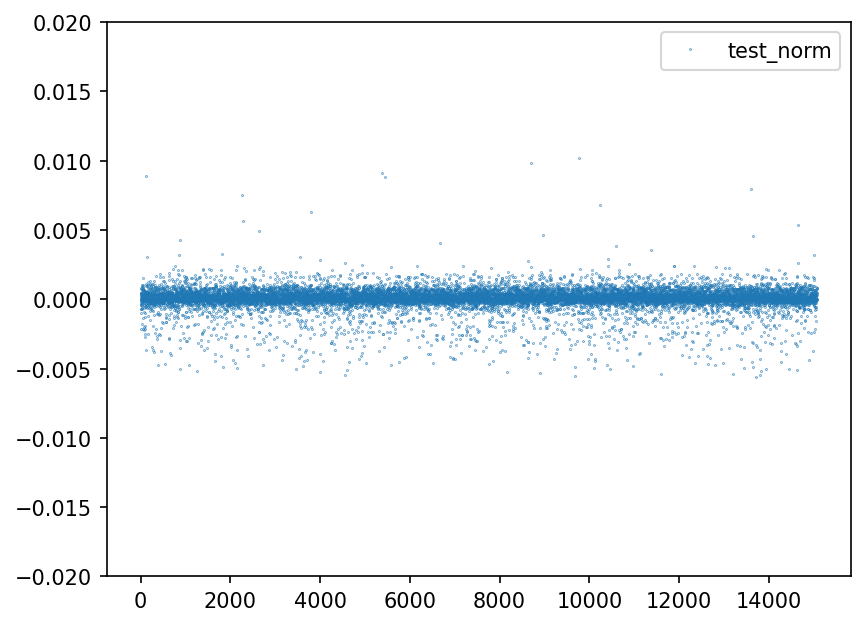

In [9]:
plt.figure(dpi=150)
plt.plot(y[:], ".",markersize=0.5, label="test_norm")
plt.ylim([-0.02, 0.02])
plt.legend()

### Creating Validation Set

In [10]:
n = len(index_val)
x_val = torch.ones(n,9)
y_val = torch.ones(n,1)
for i in range(n):
    for j in range(9):
        x_val[i][j]= data_x[j][index_val[i]]
    y_val[i] = data_y[index_val[i]]

Check if normalized or not:

In [11]:
print(min(x[:,0]), max(x[:,0]))


tensor(0.0043) tensor(1.8856)


# Defintion Neural Network

In [12]:
class Simple_Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Dense1 = nn.Linear(9, 30)
        self.Dense2 = nn.Linear(30, 30)
        self.Dense3 = nn.Linear(30, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.Dense1(x)
        x = self.relu(x)
        x = self.Dense2(x)
        x = self.relu(x)
        x = self.Dense3(x)

        return x
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(9, 30)  
        self.linear2 = nn.Linear(30, 40) 
        self.linear3 = nn.Linear(40, 20)
        self.linear4 = nn.Linear(20, 1)  

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        return x


In [ ]:
neural_net = Simple_Neural_Net()

In [13]:
neural_net = FCNN()

In [14]:
# Here we use the Adam optimizer.
learning_rate = 0.005
optimizer = torch.optim.Adam(neural_net.parameters())

In [15]:
# MSE loss function
loss_fn = torch.nn.MSELoss()

# Training

In [16]:
def train_step(model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    pred = model(x)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss = loss.item()
    return loss

In [17]:
def validate_step(model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    pred = model(x_val)
    loss = loss_fn(pred, y_val)

    loss = loss.item()
    return loss

In [18]:
epochs = 1500
Loss = np.zeros(epochs)
V_Loss = np.zeros(epochs)
for t in range(epochs):
    Loss[t] = train_step(neural_net, loss_fn, optimizer)
    V_Loss[t] = validate_step(neural_net, loss_fn, optimizer)
    if np.mod(t, 200) == 0:
        print(f"Loss at Epoch {t+1} is ", Loss[t])

Loss at Epoch 1 is  21.817150115966797
Loss at Epoch 201 is  0.002737827831879258
Loss at Epoch 401 is  0.0013339597498998046
Loss at Epoch 601 is  0.0007755764527246356
Loss at Epoch 801 is  0.0005474819918163121
Loss at Epoch 1001 is  0.0004139801603741944
Loss at Epoch 1201 is  0.00031094372388906777
Loss at Epoch 1401 is  0.0002547713229432702


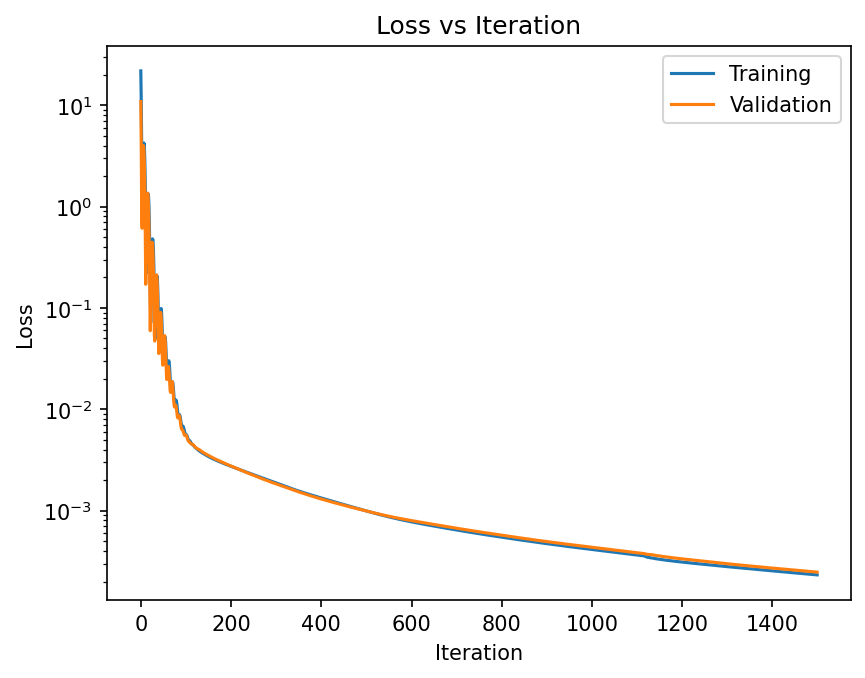

In [19]:
plt.figure(dpi=150)
plt.plot(Loss, label = "Training")
plt.plot(V_Loss, label = "Validation")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.legend()
plt.show()

# Testing

### Creating Test-Data-Set

In [20]:
n = len(index_test)
xt = torch.ones(n,9)
for i in range(n):
    for j in range(9):
        xt[i][j]= data_x[j][index_test[i]]

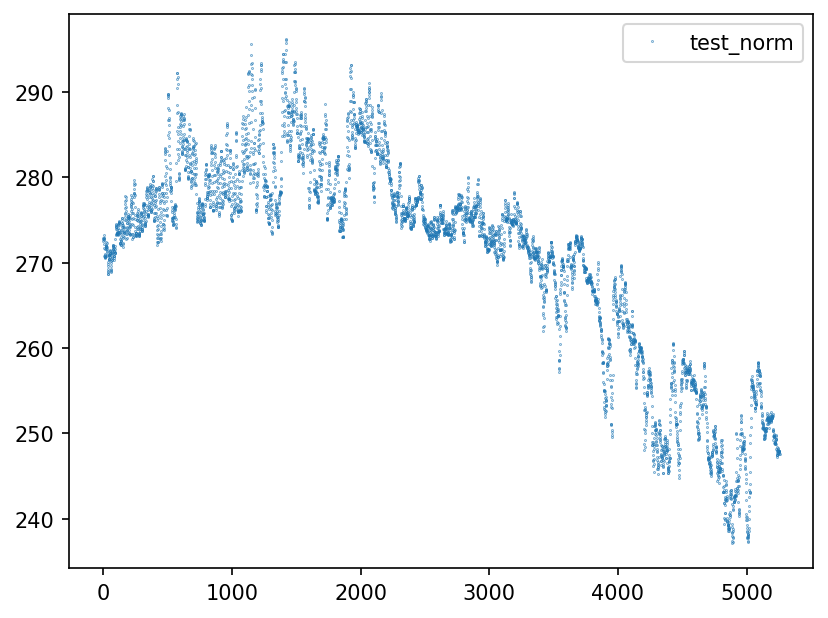

In [21]:
plt.figure(dpi=150)
plt.plot(xt[:,3], ".",markersize=0.5, label="test_norm")


plt.legend()

In [22]:
# Generate some points where the predictions of the model will be tested.
# Here we pick the testing domain to be larger than the training domain to check if the model
# has any skill at extrapolation.

y_ml_pred = torch.zeros(len(index_test)+1)
x_test = torch.ones(9)
prediction = []
for i in range(len(index_test)):
    for j in range (1,9):  # to avoid writing in the place of predicted field 
        x_test[j] = xt[i,j]
    if i == 0:
        x_test[0] = xt[0,0]
    else:
        x_test[0] = y_ml_pred[i]
    pred = neural_net(x_test).detach().numpy()
    prediction.append(pred)
    pred = torch.from_numpy(pred)
    y_ml_pred[i+1] = max(pred + x_test[0],0.)

# store icepack output for comparison with predicted result
y_test = torch.ones(len(index_test))
for i in range(len(index_test)):
    y_test[i] = data_y_orig_thic[index_test[i]]

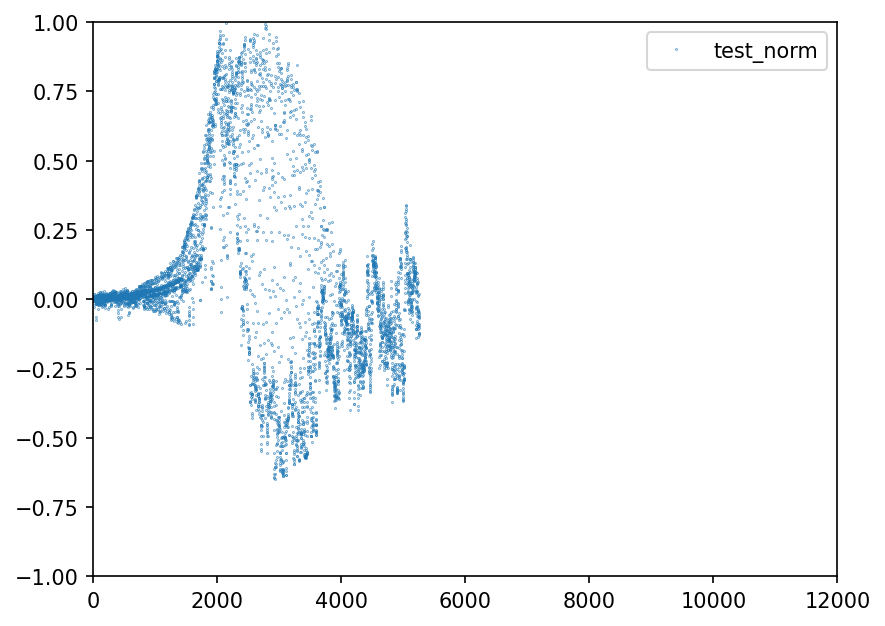

In [23]:
plt.figure(dpi=150)
plt.plot(prediction, ".",markersize=0.5, label="test_norm")

plt.ylim(-1,1)
plt.xlim(0,12000)
plt.legend()

## Comparing prediction to ICEPACK-Data

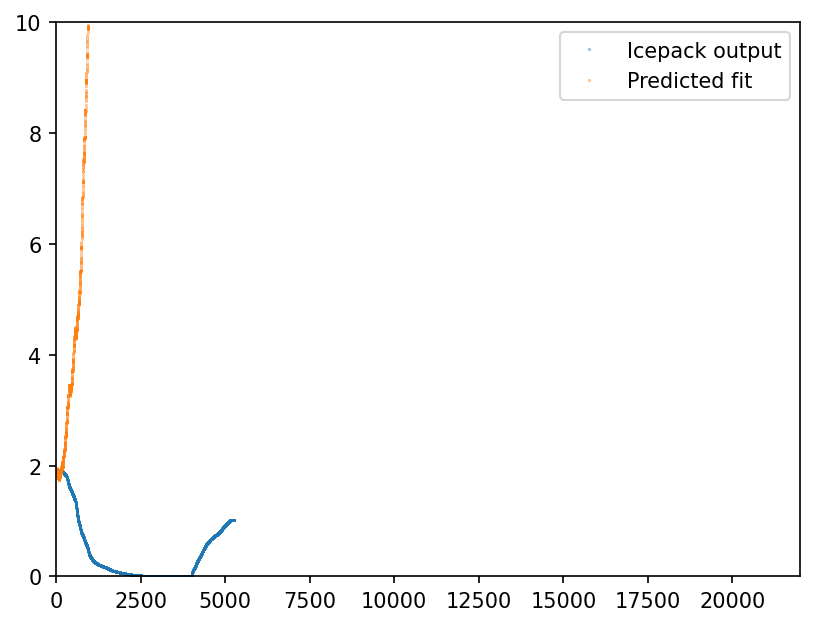

In [24]:
plt.figure(dpi=150)

plt.plot(y_test, ".", markersize=0.5, label="Icepack output")
plt.plot(y_ml_pred,".", markersize=0.5, label="Predicted fit")
plt.ylim(0,10)
plt.xlim(0,22000)
plt.legend()

## Difference between prediction and ICEPACK-Data

In [ ]:
plt.plot(y_test - pred.flatten(), 'o', markersize=0.5, label = 'Difference');
plt.title("ICEPACK - Predicted");
plt.legend();

# Validation